# Week6 Time Series 정규세션 과제

### 주가 데이터를 활용하여 자유롭게 시계열분석을 진행해주세요.
### Box-Jenkins 방법론
- 식별
- 추정
- 진단
- 예측

In [2]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.9 MB/s eta 0:00:00


1. 식별(Identification):  
데이터 유형 확인: 주어진 시계열 데이터가 정상 시계열인지 아닌지를 판별합니다.  
p, d, q 값 선택: AR(p), 차분(d), MA(q)의 차수를 선택합니다. ACF와 PACF 플롯을 통해 자기회귀 차수(p)와 이동평균 차수(q)의 적절한 값을 예측할 수 있습니다.  
데이터 취득:
주가 데이터 수집: 금융 API 또는 다른 데이터 소스를 사용하여 주가 데이터를 수집합니다.
시계열의 플로팅:  
데이터 시각화: 추세 및 계절성 여부를 파악하기 위해 시계열 데이터를 플롯합니다.
정상성 검정:  
Dickey-Fuller 검정 사용: 데이터가 정상 시계열인지 확인하기 위해 Dickey-Fuller 검정과 같은 통계적 방법을 사용합니다.  
차분:  
정상성 확보: 비정상 시계열 데이터를 차분을 통해 정상 시계열로 변환합니다.  
ACF와 PACF 플롯:  
p와 q의 예측: 자기상관함수(ACF)와 편자기상관함수(PACF) 플롯을 통해 적절한 p와 q 값을 도출합니다.    

2. 추정(Estimation):  
모델 계수 추정: 식별된 p, d, q 값을 가지고 ARIMA 모델의 계수를 추정합니다.  
여러 ARIMA 모델 적합: 가능한 여러 ARIMA(p, d, q) 모델을 적합시켜 본 다음 최적의 모델을 찾아냅니다.  
최대우도추정(MLE): 모델의 계수를 최대우도추정 또는 다른 방법을 사용하여 추정합니다.  
적합도 평가: 다양한 통계적 기준(예: AIC, BIC)을 사용하여 최적의 모델을 선택합니다.  

3. 진단(Diagnostic Checking):  
잔차 분석: 잔차가 정규 분포를 따르는지 확인하고, 자기상관성이 없는지 검증합니다.  
통계적 검정: 잔차의 자기상관성 유무를 검정하기 위해, Ljung-Box 검정을 수행합니다.   

4. 예측(Forecasting):    
데이터 분할: 시계열 데이터를 학습 데이터와 검증 데이터로 분할합니다.  
분할된 데이터로 모델 적합: 학습 데이터에 모델을 적합시킨 후, 검증 데이터에서의 성능을 평가합니다.  
미래 값에 대한 예측 수행: 적합한 모델이 확인되면 미래 값에 대한 예측을 수행합니다.

## 라이브러리 불러오기

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMAResults

<ipython-input-3-1e3c1defb90d>:12: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## 주가 데이터 불러오기
- 예) 삼성 005930.KS

In [4]:
samsung_df = yf.download('005930.KS',
                      start='2020-01-01',
                      end='2021-04-21',
                      progress=False)

samsung_df = samsung_df[["Close"]]

samsung_df = samsung_df.reset_index()

samsung_df.columns = ['day', 'price']

samsung_df['day'] = pd.to_datetime(samsung_df['day'])

samsung_df.index = samsung_df['day']
samsung_df.set_index('day', inplace=True)

samsung_df

,price
day,
2020-01-02,55200.0
2020-01-03,55500.0
2020-01-06,55500.0
2020-01-07,55800.0
2020-01-08,56800.0
...,...
2021-04-14,84000.0
2021-04-15,84100.0
2021-04-16,83900.0


In [ ]:
## Auto ARIMA

In [6]:
train = samsung_df['price'][:int(0.8*len(samsung_df))]
test = samsung_df['price'][int(0.8*len(samsung_df)):]

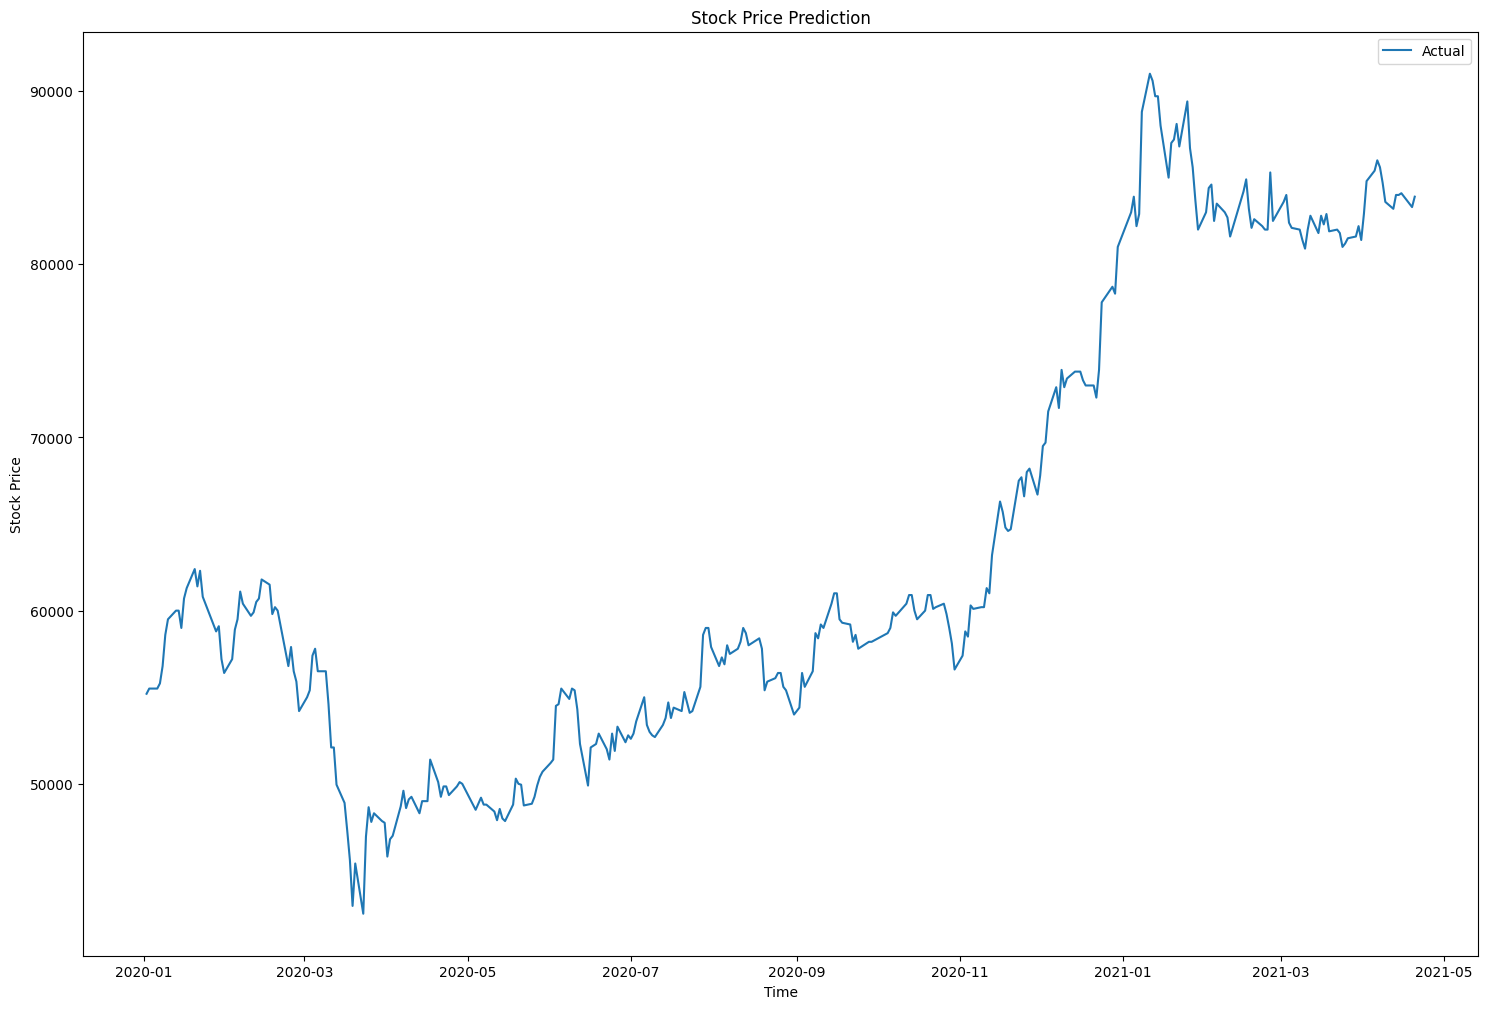

In [11]:
plt.figure(figsize=(18,12))
plt.plot(samsung_df['price'], label='Actual')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

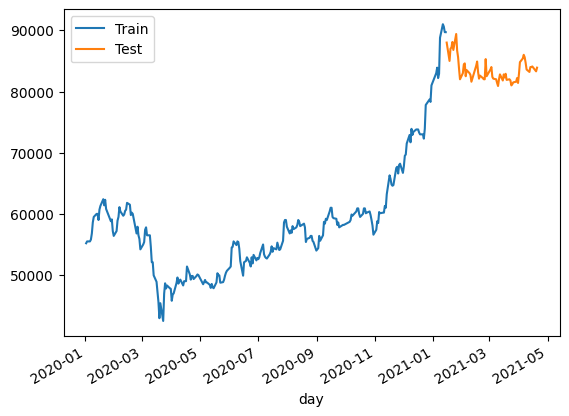

In [7]:
train.plot(label='Train')
test.plot(label='Test')
plt.legend()
plt.show()

## 최적 차분 수 구하기

In [8]:
import pmdarima as pm

kpss_diffs = pm.arima.ndiffs(train, alpha=0.05, test='kpss', max_d=5)
adf_diffs = pm.arima.ndiffs(train, alpha=0.05, test='adf', max_d=5)
n_diffs = max(kpss_diffs, adf_diffs)

print(f"Optimized 'd' = {n_diffs}")

Optimized 'd' = 2


In [9]:
model = pm.auto_arima(y=train,
                      d=n_diffs,	# 차분 (d), 기본값 = None
                      start_p= 0,	# 시작 p값, 기본값 = 2
                      max_p = 5,	# p 최대값, 기본값 = 5
                      start_q= 0,	# 시작 q값, 기본값 = 2
                      max_q = 5,	# q 최대값, 기본값 = 5
                      m=1,			# season의 주기, 기본값 = 1
                      seasonal=False,	# sARIMA를 실시, 기본값 = True
                      stepwise=True,	# stepwise algorithm, 기본값 = True
                      trace=True)		# 각 step을 출력할지, 기본값 = False


Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=4509.073, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=4491.356, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=4479.705, Time=0.46 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=4507.081, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=4455.567, Time=0.89 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=4456.766, Time=0.60 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=4457.914, Time=0.74 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=4461.548, Time=0.54 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=4482.553, Time=0.13 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=4464.285, Time=0.86 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=4454.087, Time=0.32 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=4477.900, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=4489.369, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=4458.293, Time=0.17 sec
 ARIMA(1,2,2)(0,0,0)[0]          

In [10]:
model2 = pm.auto_arima(train, d=1, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4370.535, Time=1.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4363.856, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4365.500, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4365.525, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4365.027, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4367.499, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.696 seconds


In [12]:
print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  257
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2179.928
Date:                Mon, 26 Feb 2024   AIC                           4363.856
Time:                        12:08:31   BIC                           4370.946
Sample:                             0   HQIC                          4366.708
                                - 257                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    134.7656     79.970      1.685      0.092     -21.973     291.504
sigma2      1.458e+06   9.37e+04     15.569      0.000    1.27e+06    1.64e+06
Ljung-Box (L1) (Q):                   0.90   Jarque-

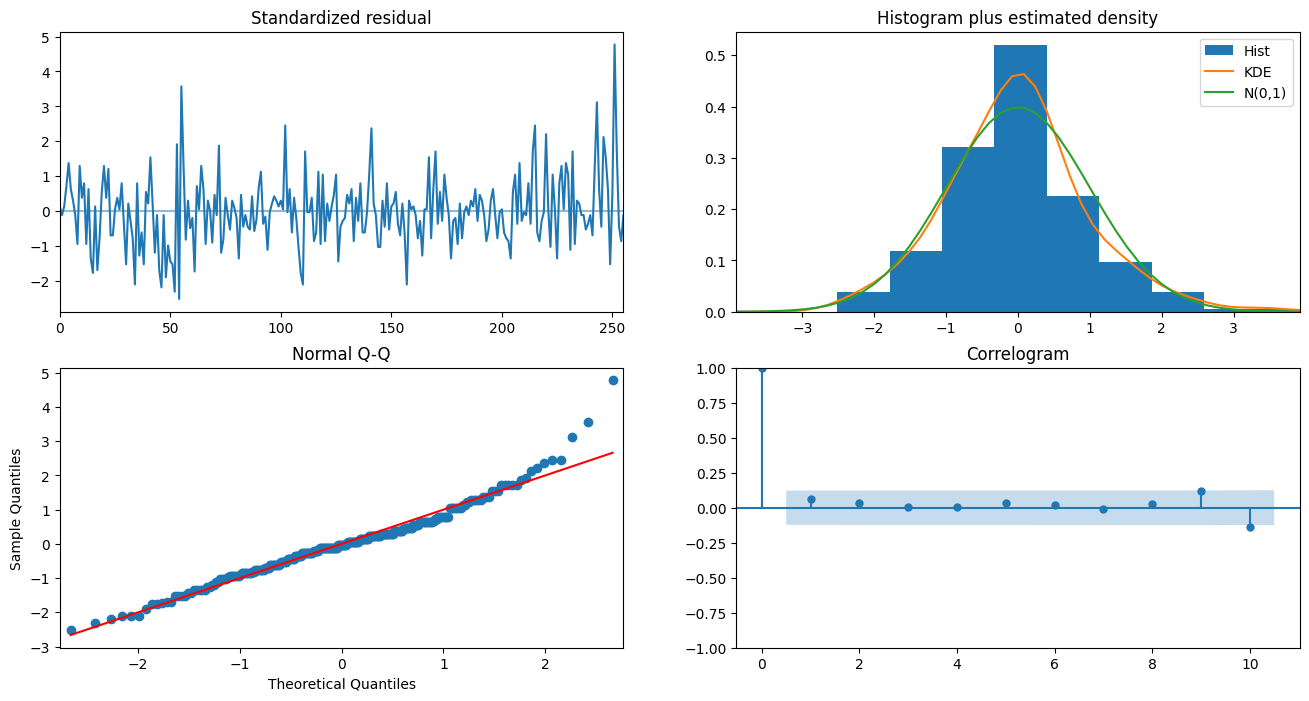

In [13]:
# 진단(Diagnostic Checking): 적합된 모델이 데이터를 잘 설명하는지 진단
model2.plot_diagnostics(figsize=(16,8))
plt.show()

## 예측(Forecasting)

In [14]:
# 예측 -> 리스트로 변환
pred = model2.predict(n_periods=len(test)).to_list()

test_pred = pd.DataFrame({'test':test, 'pred':pred}, index=test.index)
test_pred

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,test,pred
day,,
2021-01-15,88000.0,89834.765625
2021-01-18,85000.0,89969.531250
2021-01-19,87000.0,90104.296875
2021-01-20,87200.0,90239.062500
2021-01-21,88100.0,90373.828125
...,...,...
2021-04-14,84000.0,97920.703125
2021-04-15,84100.0,98055.468750
2021-04-16,83900.0,98190.234375


In [24]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=train.index, y=train, mode='lines', name='Train'))

fig.add_trace(go.Scatter(x=test.index, y=test, mode='lines', name='Test'))

fig.add_trace(go.Scatter(x=test_pred.index, y=test_pred['pred'], mode='lines', name='Predicted'))

fig.update_layout(title='Plotly Graph', xaxis_title='Index', yaxis_title='Values')

fig.show()


In [16]:
# one point forcast 함수 정의, 신뢰구간도 함께 담아보기
def forcast_one_step():
    fc, conf = model2.predict(n_periods=1, return_conf_int=True)
    return fc.tolist()[0], np.asarray(conf).tolist()[0]

# 값들을 담을 빈 리스트를 생성
y_pred = []
pred_upper = []
pred_lower = []

# for문을 통한 예측 및 모델 업데이트를 반복함
for new_ob in test:
    fc, conf = forcast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])
    model2.update(new_ob)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [17]:
test_pred2 = pd.DataFrame({'test':test, 'pred':y_pred})
y_pred_df = test_pred2['pred']
y_pred_df

day
2021-01-15    89834.765625
2021-01-18    88134.765625
2021-01-19    85119.326221
2021-01-20    87119.326221
2021-01-21    87319.326221
                  ...     
2021-04-14    84088.680572
2021-04-15    84088.806645
2021-04-16    84190.407703
2021-04-19    83990.407703
2021-04-20    83390.407703
Name: pred, Length: 65, dtype: float64

In [22]:
import plotly.express as px

fig = px.line(train, x=train.index, y=train.values, labels={'x':'Date', 'y':'Value'}, title='Train Data')
fig.add_scatter(x=test.index, y=test.values, mode='lines', name='Test')
fig.add_scatter(x=y_pred_df.index, y=y_pred_df.values, mode='lines', name='Predicted')
fig.show()


In [19]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  322
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2736.900
Date:                Mon, 26 Feb 2024   AIC                           5477.800
Time:                        12:11:11   BIC                           5485.343
Sample:                             0   HQIC                          5480.811
                                - 322                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     90.4077     71.380      1.267      0.205     -49.494     230.310
sigma2      1.501e+06   8.95e+04     16.779      0.000    1.33e+06    1.68e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                61.49
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                             0.54
Prob(H) (two-sided):                  0.12   Kurtosis:                         4.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
# sklearn으로 MAPE 계산
from sklearn.metrics import mean_absolute_percentage_error
print(f"MAPE : {mean_absolute_percentage_error(test, y_pred):.3f}")

# numpy로 직접 계산
def MAPE(y_test, y_pred):
	return np.mean(np.abs((test - y_pred) / y_test))
print(f"MAPE : {MAPE(test, y_pred):.3f}")

MAPE : 0.012
MAPE : 0.012
